In [24]:
using Revise
using DrWatson

In [25]:
@quickactivate :ReactiveMPPaperExperiments

In [26]:
using ForneyLab
using BenchmarkTools
using Random
using LinearAlgebra

In [27]:
import Distributions

In this section we want to compare results and performance of ReactiveMP.jl with another probabilistic programming library which is called ForneyLab.jl.

In [289]:
n = 200
d = 4
seed = 42

42

In [290]:
function make_benchmark_data(n, d, seed)
    rng = MersenneTwister(seed)

    A = random_rotation_matrix(rng, d)
    B = Matrix(Diagonal(ones(d) .+ rand(rng, -0.5:0.1:1.0, d)))
    P = Matrix(Diagonal(2.0 * ones(d)))
    Q = Matrix(Diagonal(2.0 * ones(d)))

    params = @strdict n d seed A B P Q

    x, y = generate_data(LGSSMModel(), params)

    return x, y, params
end

make_benchmark_data (generic function with 1 method)

In [291]:
x_data, y_data, params = make_benchmark_data(n, d, seed);

In [292]:
g = FactorGraph()

model_d = params["d"]
model_n = params["n"]
model_A = params["A"]
model_B = params["B"]
model_P = params["P"]
model_Q = params["Q"]

@RV x0 ~ GaussianMeanVariance(zeros(model_d), Matrix(Diagonal(100.0 * ones(model_d)))) # Prior

x = Vector{Variable}(undef, model_n) # Pre-define vectors for storing latent and observed variables
y = Vector{Variable}(undef, model_n)

x_t_prev = x0

for t = 1:model_n
    @RV x[t] ~ GaussianMeanVariance(model_A*x_t_prev, model_P) # Process model
    @RV y[t] ~ GaussianMeanVariance(model_B*x[t], model_Q) # Observation model

    placeholder(y[t], :y, dims=(model_d,), index=t) # Indicate observed variable
    
    x_t_prev = x[t] # Prepare state for next section
end
;

In [293]:
@time begin
    algo = messagePassingAlgorithm(x) # Generate algorithm
    source_code = algorithmSourceCode(algo) # Generate source code for algorithm
    eval(Meta.parse(source_code)); # Load algorithm
end

 88.601242 seconds (10.60 M allocations: 5.679 GiB, 1.15% gc time)


step! (generic function with 3 methods)

In [294]:
@time begin
    algo = messagePassingAlgorithm(x) # Generate algorithm
    source_code = algorithmSourceCode(algo) # Generate source code for algorithm
    eval(Meta.parse(source_code)); # Load algorithm
end

 88.016589 seconds (10.25 M allocations: 5.661 GiB, 1.20% gc time)


step! (generic function with 3 methods)

In [295]:
# For DIMENSION = 2

# NOTE: ForneyLab compilation times vary from time to time

# Because of the global evaluation we cannot robustly perform this benchmark in a loop like we did for Turing and ReactiveMP
# So we change number of observations by hand and perform benchmarks separately 
# ForneyLab model creation time times
# 50 - 22.726305 seconds (2.51 M allocations: 1.354 GiB, 1.31% gc time)
# 100 - 47.139422 seconds (5.06 M allocations: 2.732 GiB, 1.20% gc time)
# 200 - 86.241535 seconds (10.19 M allocations: 5.557 GiB, 1.28% gc time)
# 250 - 117.509299 seconds (12.82 M allocations: 7.001 GiB, 1.32% gc time)
# 300 - 137.006022 seconds (15.31 M allocations: 8.469 GiB, 1.22% gc time)

In [296]:
# For DIMENSION = 4

# NOTE: ForneyLab compilation times vary from time to time

# Because of the global evaluation we cannot robustly perform this benchmark in a loop like we did for Turing and ReactiveMP
# So we change number of observations by hand and perform benchmarks separately 
# ForneyLab model creation time times
# 50 - 23.327590 seconds (2.52 M allocations: 1.362 GiB, 1.25% gc time)
# 100 - 46.829628 seconds (5.27 M allocations: 2.771 GiB, 1.31% gc time)
# 200 - 88.016589 seconds (10.25 M allocations: 5.661 GiB, 1.20% gc time)
# 250 - 119.371944 seconds (13.33 M allocations: 7.185 GiB, 1.83% gc time)
# 300 - 136.036903 seconds (15.92 M allocations: 8.722 GiB, 1.19% gc time)

In [297]:
data = Dict(:y => y_data) # Prepare data dictionary
;

In [298]:
@time step!(data);

318.073160 seconds (6.42 M allocations: 277.403 MiB, 0.03% gc time, 100.00% compilation time)


In [299]:
# For DIMENSION = 2

# ForneyLab compilation time
# 50 - 15.300824 seconds (1.68 M allocations: 76.275 MiB, 0.17% gc time, 99.95% compilation time)
# 100 - 65.614497 seconds (3.17 M allocations: 139.568 MiB, 0.09% gc time, 99.94% compilation time)
# 200 - 288.590772 seconds (6.21 M allocations: 269.570 MiB, 0.03% gc time, 99.99% compilation time)
# 250 - 557.830418 seconds (7.73 M allocations: 332.040 MiB, 0.02% gc time, 99.94% compilation time)
# 300 - 920.685297 seconds (9.25 M allocations: 395.463 MiB, 0.01% gc time, 99.97% compilation time)

In [300]:
# For DIMENSION = 4

# ForneyLab compilation time
# 50 - 17.412056 seconds (1.70 M allocations: 76.766 MiB, 0.20% gc time, 99.94% compilation time)
# 100 - 65.860935 seconds (3.27 M allocations: 143.514 MiB, 0.06% gc time, 99.92% compilation time)
# 200 - 318.073160 seconds (6.42 M allocations: 277.403 MiB, 0.03% gc time, 100.00% compilation time)
# 250 - 569.752148 seconds (8.05 M allocations: 345.758 MiB, 0.04% gc time, 99.95% compilation time) 
# 300 - 868.833146 seconds (9.56 M allocations: 407.149 MiB, 0.01% gc time, 99.99% compilation time)

In [301]:
@time step!(data);

  0.010771 seconds (79.69 k allocations: 9.243 MiB)


In [302]:
@time step!(data);

  0.010298 seconds (79.69 k allocations: 9.243 MiB)


In [303]:
@btime step!(data);

  7.681 ms (79695 allocations: 9.24 MiB)


In [304]:
inferred = step!(data) # Execute inference
marginals = map(i -> inferred[Symbol(:x_, i)], 1:model_n) 
;

In [305]:
average_mse(x_data, marginals) ./ n

7.6515537436790035

In [306]:
# For DIMENSION = 2

# ForneyLab execution times and E[MSE]
# 50 - 1.765 ms (19742 allocations: 2.07 MiB) | E[MSE] = 4.124469240478788
# 100 - 4.036 ms (39642 allocations: 4.15 MiB) | E[MSE] = 4.1718819514395955
# 200 - 6.128 ms (79695 allocations: 8.34 MiB) | E[MSE] = 4.082831166403034
# 250 - 10.248 ms (99600 allocations: 10.42 MiB) | E[MSE] = 4.0585925696062155
# 300 - 11.570 ms (119501 allocations: 12.50 MiB) | E[MSE] = 3.96470532342949

In [307]:
# For DIMENSION = 4

# ForneyLab execution times and E[MSE]
# 50 - 2.302 ms (19742 allocations: 2.30 MiB) | E[MSE] = 8.27522311036124
# 100 - 3.579 ms (39642 allocations: 4.60 MiB) | E[MSE] = 8.004955278503026
# 200 - 7.681 ms (79695 allocations: 9.24 MiB) | E[MSE] = 7.6515537436790035
# 250 - 12.099 ms (99600 allocations: 11.55 MiB) | E[MSE] = 7.736329375309611
# 300 - 12.685 ms (119501 allocations: 13.86 MiB) | E[MSE] = 7.750883079446451

In [287]:
using CairoMakie

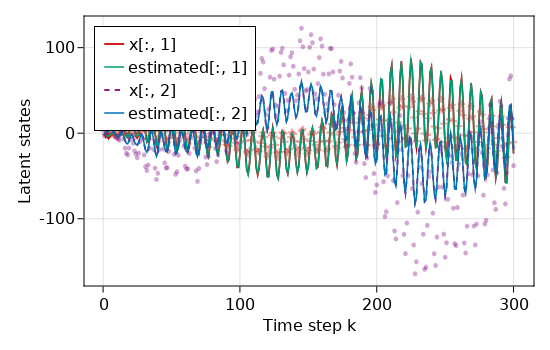

In [288]:
let
    c = Makie.wong_colors() 

    x_inferred_means = ForneyLab.unsafeMean.(marginals)
    x_inferred_stds  = map(e -> sqrt.(e), ForneyLab.unsafeVar.(marginals))
    
    range = 1:length(x_inferred_means)

    fig = Figure(resolution = (550, 350))
    ax  = Axis(fig[1, 1], xlabel = "Time step k", ylabel = "Latent states")

    # Real dim1
    lines!(ax, range, x_data |> edim(1), color = :red3, linewidth = 1.75, label = "x[:, 1]",)
    scatter!(ax, range, y_data |> edim(1), color = (:red3, 0.35), markersize = 10, marker = :cross)

    # Estimated dim1

    lines!(ax, range, x_inferred_means |> edim(1), color = c[3], label = "estimated[:, 1]")
    band!(ax, range, (x_inferred_means |> edim(1)) .+ (x_inferred_stds |> edim(1)), (x_inferred_means |> edim(1)) .- (x_inferred_stds |> edim(1)), color = (c[3], 0.65))

    # Real dim2

    lines!(ax, range, x_data |> edim(2), color = :purple, linewidth = 1.75, linestyle = :dash, label = "x[:, 2]")
    scatter!(ax, range, y_data |> edim(2), color = (:purple, 0.35),markersize = 6, marker = :circle)

    # Estimated dim2

    lines!(ax, range, x_inferred_means |> edim(2), color = c[1], label = "estimated[:, 2]")
    band!(ax, range, (x_inferred_means |> edim(2)) .+ (x_inferred_stds |> edim(2)), (x_inferred_means |> edim(2)) .- (x_inferred_stds |> edim(2)), color = (c[1], 0.65))

    axislegend(ax, position = :lt)

    fig
end